In [1]:
import serial
import time

import matplotlib.pyplot as plt
from surya.debug.render_html import filepath
# %config InlineBackend.figure_formats = ['svg']

from analysis_lib import KeysightInfiniiVisionMSO, DEFAULT_LABELS
from analysis_lib.decoder import RawDecoder, RawDecodeResult, RawFrame, BrotherSerialDecoder, BrotherDecodeResult, DecodedByte
from analysis_lib.plotting import plot_digital, plot_digital_normalized
from analysis_lib.capture import Capture

ADDRESS = "USB0::2391::5925::MY49110266::INSTR"

INTERFACE = "IF60"
TYPEWRITER = "AX20"
KEYBOARD = 1 # Typenrad Selection Switch: 1=LOCAL, 2=INTERNATIONAL, 3=SYMBOL

switches = [
    0,  # 1-1: UP=RS-232C, DOWN=CDCC interface
    0,  # 1-2: UP=Terminal mode, DOWN=Printer mode
    1,  # 1-3: USA users can ignore
    1,  # 1-4: UP=ASCII Wheel, DOWN=Non-ASCII Wheel
    1,  # 1-5: UP=12-inch paper, DOWN=11-inch paper
    1,  # 1-6: UP=Auto skip perforation, DOWN=Non auto skip
        #
    1,  # 2-1: UP=Local echo (half-duplex), DOWN=No echo (full-duplex)
    1,  # 2-2: UP=DC-1/DC-3 disabled, DOWN=enabled
    1,  # 2-3: UP=Auto line feed off, DOWN=double spacing
    1,  # 2-4: UP=7-bit data, DOWN=8-bit data
    1,  # 2-5: UP=Even parity, DOWN=Odd parity
        #
    1,  # 2-6:  DOWN    DOWN    DOWN    DOWN    UP      UP      UP      UP
    1,  # 2-7:  DOWN    DOWN    UP      UP      DOWN    DOWN    UP      UP
    1,  # 2-8:  DOWN    UP      DOWN    UP      DOWN    UP      DOWN    UP
        # BAUD  9600    4800    2400    1200    600     300     150     110
]

DIP_SWITCHES = sum(bit << i for i, bit in enumerate(switches))

def setup_scope(time_scale=1.5e-4, delay=4.5e-4, trigger_channel=4, trigger_slope="NEGative"):
    """
    Quick scope setup for notebook use
    """
    scope = KeysightInfiniiVisionMSO(ADDRESS)

    scope.setup_digital_channels(
        channels=range(6),
        threshold=2.5,
        time_scale=time_scale,
    )

    for i, label in enumerate(DEFAULT_LABELS):
        scope.set_digital_label(i, label)

    scope.setup_digital_trigger(channel=trigger_channel, slope=trigger_slope)
    scope.set_trigger_delay(delay)

    return scope

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed

Capture: SELECT
Timestamp: 2026-01-26 15:35:26
Devices: AX20 / IF60
Data: 400.00 MHz, Channels: 0:SI, 1:SO, 2:SCK, 3:KBACK, 4:READY, 5:KBRQ, 6:D6, 7:D7
Notes: Handshake between IF60 and AX20, after Transmission of DC1(Activates SEL Mode) from PC to Interface
Saved to: signal_captures/AX20_IF60/AX20_IF60_SELECT.pkl

RAW-SI: 0b11111001, 0b11111101, 0b01111111, 0b11110100, 0b10110001, 0b10110001
RAW-SO: 0b00000000, 0b00000000, 0b00000100, 0b00000000, 0b00000000, 0b00000000
DEC-SI: ACK,STX,DEL,VT,N,N
DEC-SO: NUL,NUL,EOT,NUL,NUL,NUL


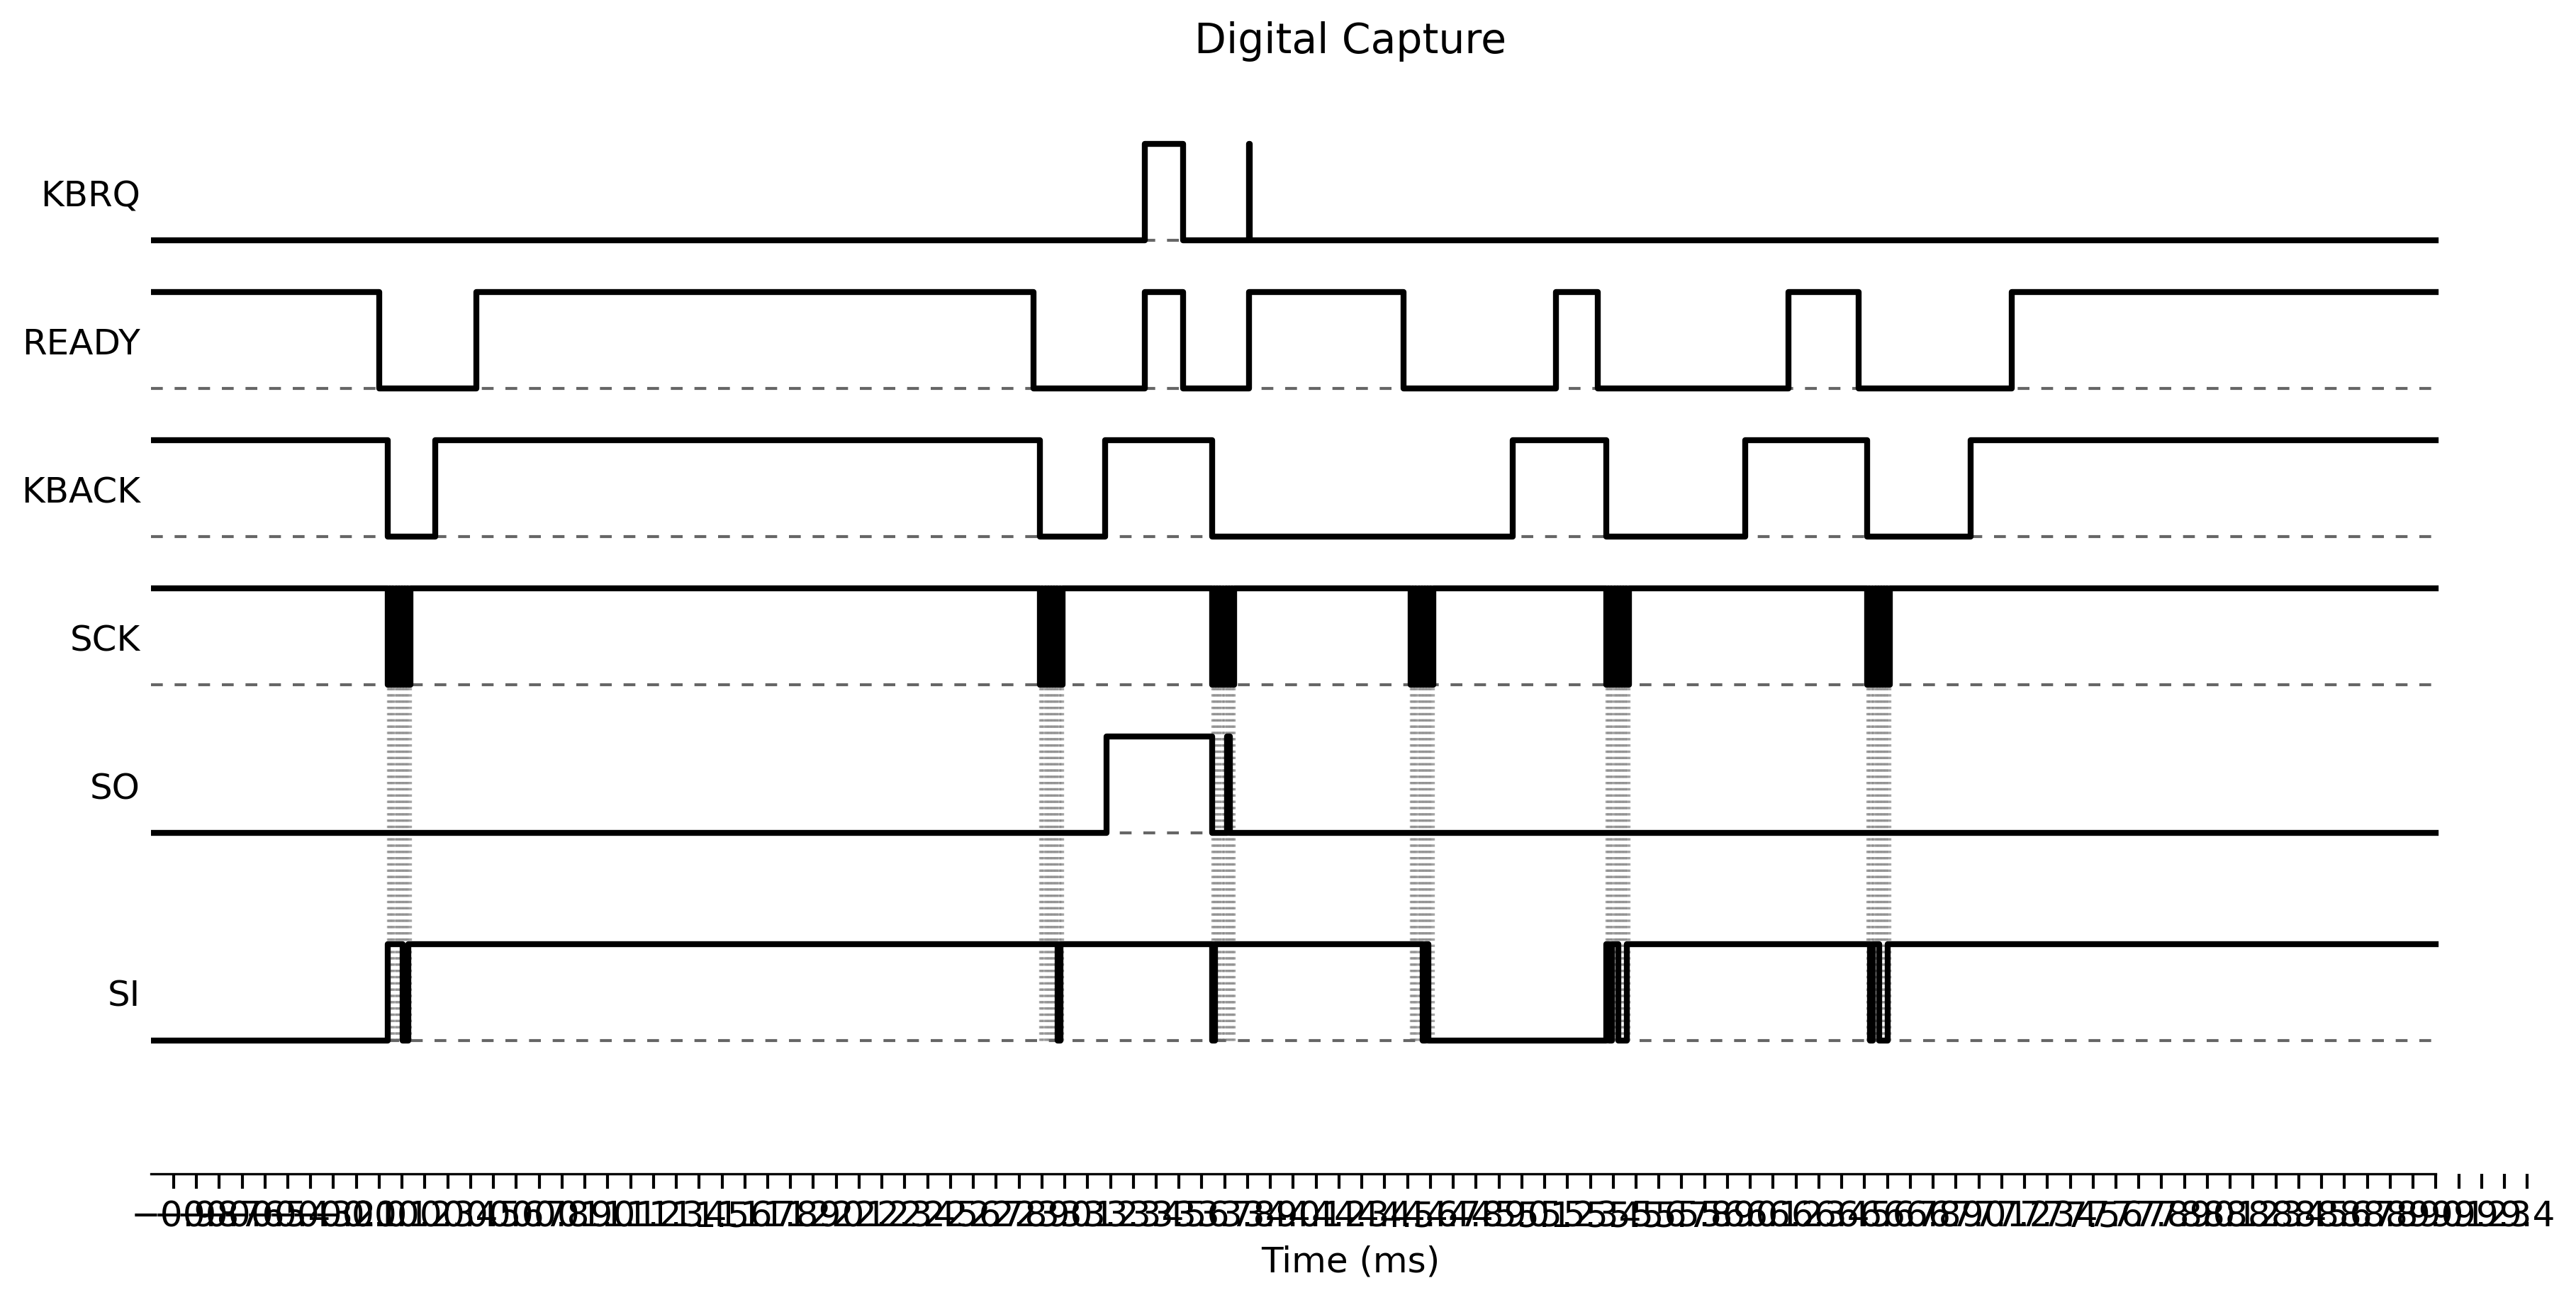

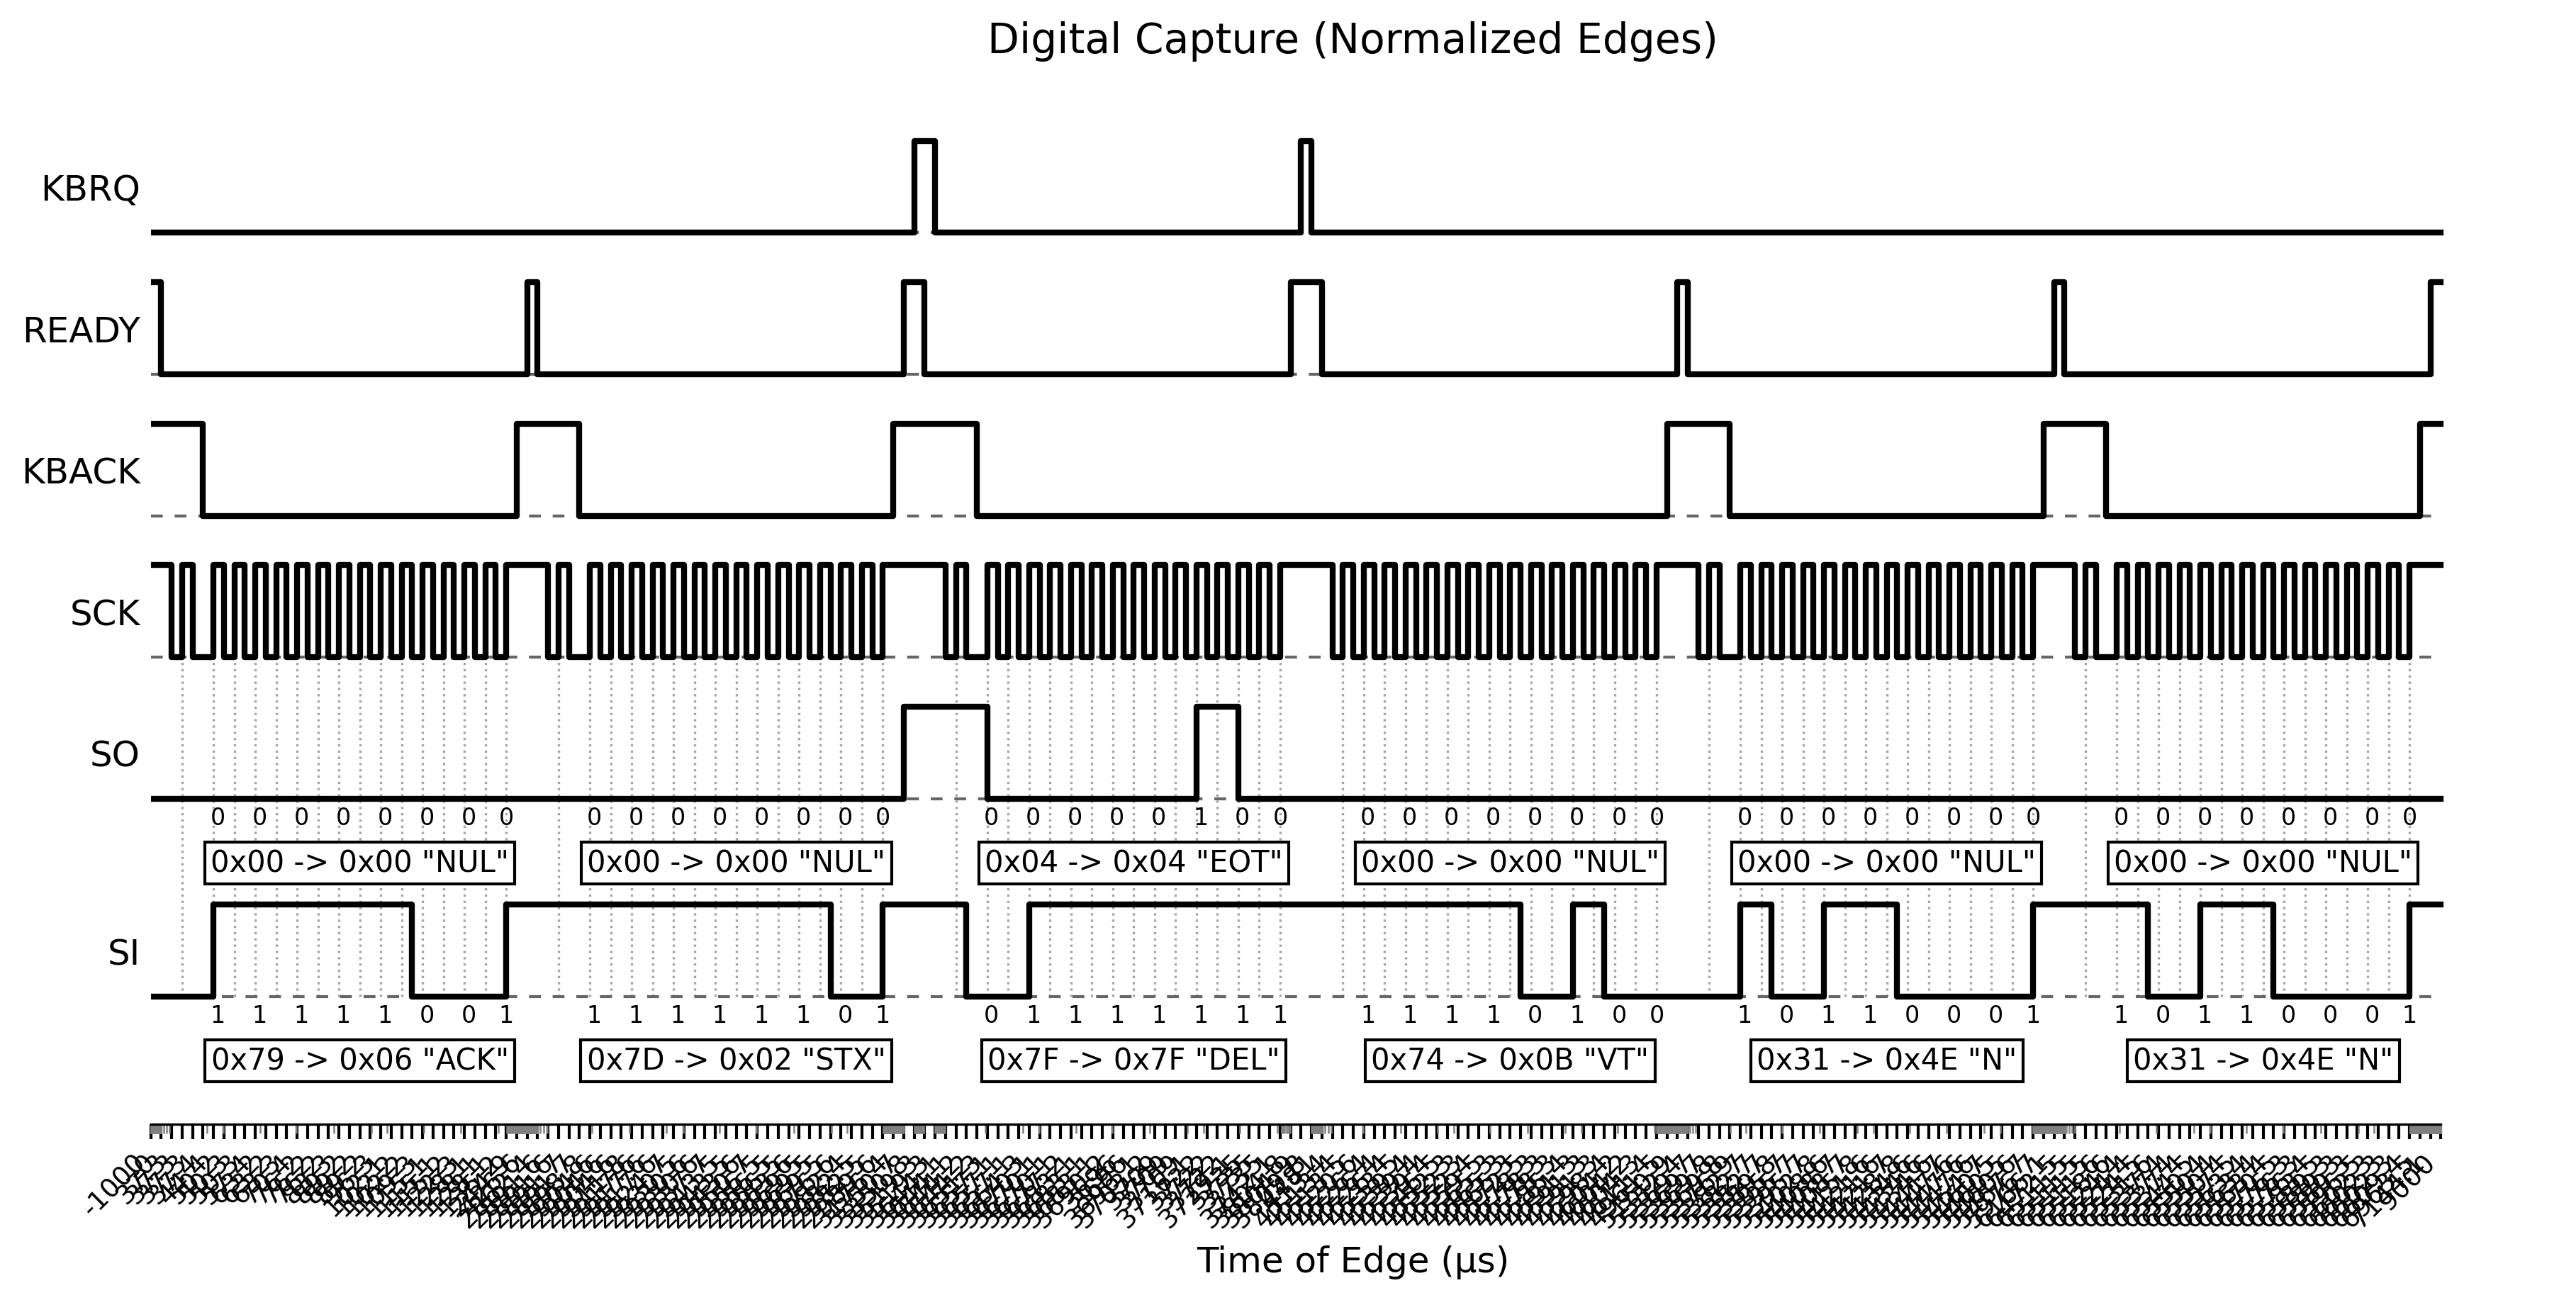

(<Figure size 3600x1800 with 1 Axes>,
 <Axes: title={'center': 'Digital Capture (Normalized Edges)'}, xlabel='Time of Edge (µs)'>)

In [3]:
# Capture Select
# START WITH INTERFACE IN DESELECTED STATE AND TYPEWRITER POWERED OFF AND ON BEFORE!
NAME = "SELECT"
INFO = "Handshake between IF60 and AX20, after Transmission of DC1(Activates SEL Mode) from PC to Interface"

with setup_scope(time_scale=0.1e-2, delay=0.4e-2, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.2)

        # DC1 Put IF-60 into Select State
        con.write(bytes([0x11]))
        time.sleep(5)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

# Create structured Capture with metadata
capture = Capture.from_scope_data(
    time_data, packed, channel_data,
    typewriter=TYPEWRITER,
    interface=INTERFACE,
    name=NAME,
    info=INFO,
    keyboard_setting=KEYBOARD,
    interface_dip_switches=DIP_SWITCHES
)

# Print Captrure Info
print(f"\n{capture.get_info()}")
# Save Capture to file
filepath = capture.save(directory=f"./signal_captures/{TYPEWRITER}_{INTERFACE}")
print(f"Saved to: {filepath}\n")

# Decode and Debounce Raw Bits
raw_decoder = RawDecoder(channel_data, time_data)
raw_si: RawDecodeResult = raw_decoder.decode(data_ch=0)
raw_so: RawDecodeResult = raw_decoder.decode(data_ch=1)
print(f"RAW-SI: {raw_si}\nRAW-SO: {raw_so}")

decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()
print(f"DEC-SI: {decoded_si}\nDEC-SO: {decoded_so}")

# Plot with annotations
annotations = (decoded_si.to_annotations(include_bits=True) + decoded_so.to_annotations(include_bits=True))

plot_digital(time_data, channel_data)
plot_digital_normalized(time_data, channel_data, annotations=annotations)
